# Домашнее задание 3.

`Keras` и сверточные нейронные сети.

In [8]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


In [9]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    if curr_session is not None:
        curr_session.close()
    K.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

## Задание 1 — инициализация весов CNN (3 балла).

В этом задании нужно будет исследовать, как выбор функции инициализации весов влияет на обучение CNN.


Продолжим работать с датасетом CIFAR-10.

In [10]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

# нормализуем входные данные
x_train = x_train / 255 - 0.5
x_test = x_test / 255 - 0.5

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model

Определим функцию `fit_model` с архитектурой архитектура CNN.

Метод `model.fit` возвращает объект класса `keras.callbacks.History()` — это колбэк, который автоматически применяется ко всем моделям и логирует много чего полезного. В частности логируются значения функции потерь на каждой итерации.

**Задание 1.1** (0.5 балла) Добавьте в архитектуру модели инициализацию весов для тех слоев, где она необходима.


In [16]:
def fit_model(initializer='glorot_normal'):
    s = reset_tf_session()  
    INIT_LR = 5e-3
    BATCH_SIZE = 32
    EPOCHS = 10
   
    def lr_scheduler(epoch):
        return INIT_LR * 0.9 ** epoch  

    ### YOUR CODE HERE 
    
    # kernel_initializer=initializer для тех слоев, которым нужна инициализация весов
    model = Sequential()
    model.add(Conv2D(filters=16, padding='same', kernel_size=(3,3), input_shape=(32,32,3),
                     kernel_initializer=initializer))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3),
                        kernel_initializer=initializer))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(40, kernel_initializer=initializer))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))    
    model.add(Dense(10, kernel_initializer=initializer))
    model.add(Activation("softmax"))


    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.adamax(lr=INIT_LR),
        metrics=['accuracy']
    )
  
    history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],                   
        shuffle=True,
        verbose=100,
        initial_epoch=0    
    )

    # Возвращаем объект класса keras.callbacks.History
    return history

**Задание 1.2** (1.5 балла). Обучите модель с разными [функциями инициализации](https://keras.io/initializers/) весов:
* `Zeros` — веса инициализируются нулями
* `Constant=0.05` — веса инициализируются константой 0.05
* `RandomUniform` — веса генерируются равномерно из отрезка [-0.05, 0.05]
* `glorot_normal` — Xavier initializer из лекций
* `lecun_uniform`

Добавьте в список `losses` значения функции потерь для каждой функции инициализации, их можно достать из `History`



In [17]:
init_weights = [keras.initializers.Zeros(),keras.initializers.Constant(value=0.05),
    keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=42),keras.initializers.lecun_uniform(seed=42),
    keras.initializers.glorot_normal(seed=42)]

In [18]:
losses = []
histories = []

for i in init_weights:
    histories.append(fit_model(i))

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10



Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10



Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [19]:
for i in range(len(init_weights)):
    losses.append(histories[i].history['loss'])

**Задание 1.3** (1 балла). Постройте графики зависимости функций потерь от номера итерации, подпишите их. Прокомментируйте результат.

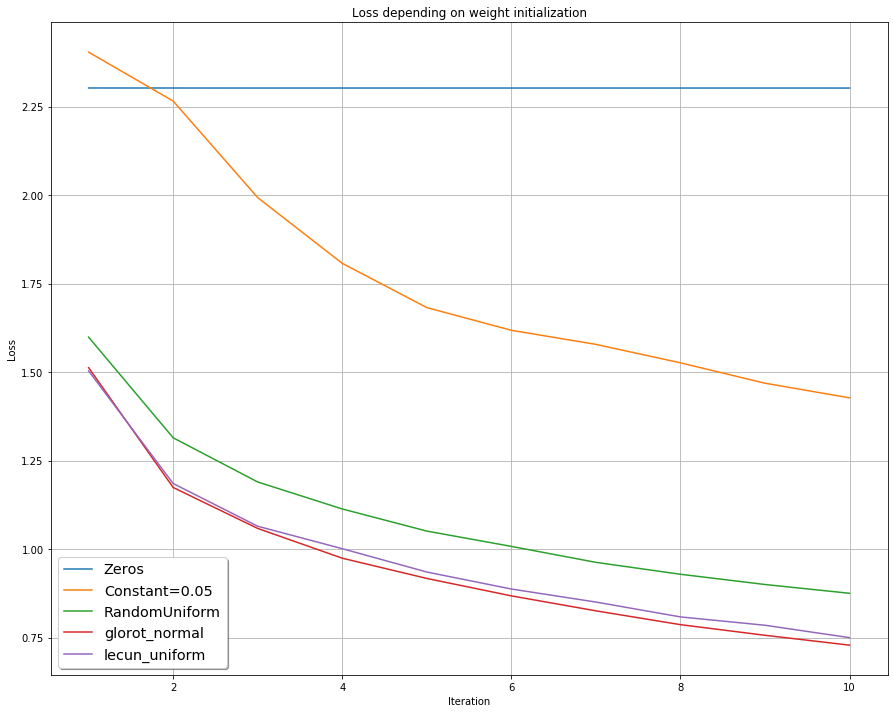

In [20]:
labels = ['Zeros', 'Constant=0.05', 'RandomUniform', 'glorot_normal', 'lecun_uniform']

plt.figure(figsize=(15, 12))
for i in range(len(losses)):
    plt.plot(np.arange(len(losses[i]))+1, losses[i], label=labels[i])

plt.title('Loss depending on weight initialization')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.grid()
plt.legend(loc='best', shadow=True, fontsize='x-large')

# Инициализация весов нулями не позволяет обучаться модели, так как градиенты обновления весов одинаковые на каждой эпохе. Инициализация константами также не показывает хорошего результата, в то время как 'glorot_normal' инициализация, в данном случае, явилась наиболее оптимальной.

## Задание 2 — CNN для CIFAR-10 с сохранением весов модели (7 баллов)

В этом задании мы модифицируем нейросеть с семинара, чтобы она достигала большего значения `accuracy` и научимся сохранять веса модели в файл во время обучения. Можно использовать только те же слои, которые использовались на семинаре: `Conv2D, MaxPooling2D,  LeakyReLU, Dropout, Flatten, Dense`.

**Задание 2.1** (4 балла). Подберите архитектуру модели так, чтобы значение `accuracy` на тестовой выборке было не менее 85.

In [76]:
def make_model():
    
    initializer = 'glorot_normal'
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer=initializer, padding='same', 
                     input_shape=(32,32,3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, (3, 3), kernel_initializer=initializer, padding='same'))
    model.add(LeakyReLU(0.1))
    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), kernel_initializer=initializer, padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, (3, 3), kernel_initializer=initializer, padding='same'))
    model.add(LeakyReLU(0.1))
    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), kernel_initializer=initializer, padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(128, (3, 3), kernel_initializer=initializer, padding='same'))
    model.add(LeakyReLU(0.1))
    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    
    model.add(Dense(256, kernel_initializer=initializer))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [77]:
s = reset_tf_session()
model = make_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

**Задание 2.2** (2 балла). Реализуйте колбэк, который сохраняет модель в `.hdf5` файл и печатает имя файла, в который была сохранена модель. Используйте функцию `model_save`. Строка с именем файла имеет вид `<name>_{0:02d}.hdf5`, отформатируйте ее так, чтобы в имени строки фигурировал номер эпохи.

In [78]:
from keras.models import save_model, load_model

class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        model.save(self.file_name.format(epoch))
        print('Model saved to: {}'.format(self.file_name.format(epoch)))


**Задание 2.3** (1 балл). Реализуйте функцию, которая с помощью `load_model` будет загружать модель из файла.

In [79]:
def load_from_file(model_filename, last_epoch):
    model = load_model(model_filename)
    epoch = last_epoch
    return model

In [80]:
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 20

model_filename = 'weights_{0:02d}.hdf5'

s = reset_tf_session()

model = make_model()

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adamax(lr=INIT_LR),
    metrics=['accuracy']
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch 

# в случае, если обучение было прервано, можно загрузить модель из файла, 
# соответствующего последней эпохе, за которую есть сохраненные веса
# model = load_from_file(model_filename, 4)
  
history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               # не забудьте передать сюда ModelSaveCallback
               ModelSaveCallback(model_filename)
              ],
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0    
)
  

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 647s 13ms/step - loss: 1.5592 - acc: 0.4269 - val_loss: 1.0921 - val_acc: 0.6101
Model saved to: weights_01.hdf5
Epoch 2/20
50000/50000 [==============================] - 584s 12ms/step - loss: 1.0817 - acc: 0.6187 - val_loss: 0.8692 - val_acc: 0.6945
Model saved to: weights_02.hdf5
Epoch 3/20
50000/50000 [==============================] - 584s 12ms/step - loss: 0.8901 - acc: 0.6929 - val_loss: 0.7497 - val_acc: 0.7410
Model saved to: weights_03.hdf5
Epoch 4/20
50000/50000 [==============================] - 674s 13ms/step - loss: 0.7926 - acc: 0.7267 - val_loss: 0.7155 - val_acc: 0.7570
Model saved to: weights_04.hdf5
Epoch 5/20
50000/50000 [==============================] - 804s 16ms/step - loss: 0.7123 - acc: 0.7516 - val_loss: 0.6769 - val_acc: 0.7721
Model saved to: weights_05.hdf5
Epoch 6/20
50000/50000 [==============================] - 673s 13ms/step - loss: 0.6539 - acc: 